<a href="https://colab.research.google.com/github/Dirkster99/PyNotes/blob/master/Transformers/LocalModelUsage_Finetuning/62_Transformer_4_Language_Classification_MultiClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install transformers==4.2.1

     |████████████████████████████████| 1.8MB 5.1MB/s 
     |████████████████████████████████| 890kB 20.3MB/s 
     |████████████████████████████████| 2.9MB 34.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=ff2d06919a75b56a0f22857fb2605445464ae4542f4e2ca172acf1b8d2585dc3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Six steps towards building a Language Classification Model with Transformers and TensorFlow 2.0

Original Author: James Briggs
https://www.youtube.com/watch?v=GYDFBfx8Ts8

## Download and Preprocessing Data

### 20 News Groups Categorization Dataset

In [8]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [9]:
dataPath = '/gdrive/MyDrive/Colab Notebooks/20_Newsgroups TextClassification/data/'
!ls {dataPath.replace(' ', '\ ')}

20news-bydate	      20_newsgroups_data.csv		   model
20news-bydate.tar.gz  20_newsgroups_data_no_filenames.csv


In [10]:
import pandas as pd
df = pd.read_csv(dataPath + '20_newsgroups_data_no_filenames.csv', sep='|')
df.head()

,category,news
0,rec.sport.baseball,From: cubbie@garnet.berkeley.edu ( ...
1,comp.sys.mac.hardware,From: gnelson@pion.rutgers.edu (Gregory Nelson...
2,sci.crypt,From: crypt-comments@math.ncsu.edu\nSubject: C...
3,alt.atheism,From: keith@cco.caltech.edu (Keith Allan Schne...
4,comp.sys.mac.hardware,From: taihou@chromium.iss.nus.sg (Tng Tai Hou)...


In [11]:
# Generate number representation for category field
df['label'] = pd.Categorical(df.category, ordered=True).codes
df['label'].unique()

array([ 9,  4, 11,  0,  5, 13, 12, 17, 10,  6,  7,  2,  8, 14,  1,  3, 16,
       18, 19, 15], dtype=int8)

In [12]:
# Map labels to humand readable category inside a dictionary
mapLabels = pd.DataFrame(df.groupby(['category', 'label']).count())

#drop count column
mapLabels.drop(['news'], axis = 1, inplace = True)
label2Index = mapLabels.to_dict(orient='index')

print (f"label2Index :{label2Index}")
print (type(label2Index))
#print (f"index2Label :{index2Label}")

label2Index :{('alt.atheism', 0): {}, ('comp.graphics', 1): {}, ('comp.os.ms-windows.misc', 2): {}, ('comp.sys.ibm.pc.hardware', 3): {}, ('comp.sys.mac.hardware', 4): {}, ('comp.windows.x', 5): {}, ('misc.forsale', 6): {}, ('rec.autos', 7): {}, ('rec.motorcycles', 8): {}, ('rec.sport.baseball', 9): {}, ('rec.sport.hockey', 10): {}, ('sci.crypt', 11): {}, ('sci.electronics', 12): {}, ('sci.med', 13): {}, ('sci.space', 14): {}, ('soc.religion.christian', 15): {}, ('talk.politics.guns', 16): {}, ('talk.politics.mideast', 17): {}, ('talk.politics.misc', 18): {}, ('talk.religion.misc', 19): {}}
<class 'dict'>


In [13]:
# generate inverse dictionary to map in both directions
index2label = {}

for key in label2Index:
  print (f"{key[1]} -> {key[0]}")
  index2label[key[1]] = key[0]

0 -> alt.atheism
1 -> comp.graphics
2 -> comp.os.ms-windows.misc
3 -> comp.sys.ibm.pc.hardware
4 -> comp.sys.mac.hardware
5 -> comp.windows.x
6 -> misc.forsale
7 -> rec.autos
8 -> rec.motorcycles
9 -> rec.sport.baseball
10 -> rec.sport.hockey
11 -> sci.crypt
12 -> sci.electronics
13 -> sci.med
14 -> sci.space
15 -> soc.religion.christian
16 -> talk.politics.guns
17 -> talk.politics.mideast
18 -> talk.politics.misc
19 -> talk.religion.misc


In [14]:
label2Index = {v: k for k, v in index2label.items()}

print (f'label2Index: {label2Index}')
print (f'index2label: {index2label}')

label2Index: {'alt.atheism': 0, 'comp.graphics': 1, 'comp.os.ms-windows.misc': 2, 'comp.sys.ibm.pc.hardware': 3, 'comp.sys.mac.hardware': 4, 'comp.windows.x': 5, 'misc.forsale': 6, 'rec.autos': 7, 'rec.motorcycles': 8, 'rec.sport.baseball': 9, 'rec.sport.hockey': 10, 'sci.crypt': 11, 'sci.electronics': 12, 'sci.med': 13, 'sci.space': 14, 'soc.religion.christian': 15, 'talk.politics.guns': 16, 'talk.politics.mideast': 17, 'talk.politics.misc': 18, 'talk.religion.misc': 19}
index2label: {0: 'alt.atheism', 1: 'comp.graphics', 2: 'comp.os.ms-windows.misc', 3: 'comp.sys.ibm.pc.hardware', 4: 'comp.sys.mac.hardware', 5: 'comp.windows.x', 6: 'misc.forsale', 7: 'rec.autos', 8: 'rec.motorcycles', 9: 'rec.sport.baseball', 10: 'rec.sport.hockey', 11: 'sci.crypt', 12: 'sci.electronics', 13: 'sci.med', 14: 'sci.space', 15: 'soc.religion.christian', 16: 'talk.politics.guns', 17: 'talk.politics.mideast', 18: 'talk.politics.misc', 19: 'talk.religion.misc'}


In [15]:
# Remoe Email address to avoid additional noise
df.news.replace(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', '', regex=True, inplace=True)

In [16]:
df.rename(columns = {'label' : 'labels', 'news' : 'text'}, inplace = True)

In [17]:
df = df[['text','labels']]

In [18]:
df.head()

,text,labels
0,From: ( )\nSubj...,9
1,From: (Gregory Nelson)\nSubject: Thanks Apple...,4
2,From: \nSubject: Cryptography FAQ 10/10 - Refe...,11
3,From: (Keith Allan Schneider)\nSubject: Re: <...,0
4,From: (Tng Tai Hou)\nSubject: ADB and graphic...,4


In [19]:
# Drop duplicates to avoid pulliting the test data set with previously seen training data
# when doing a simple test/train split on 1 file instead of using 2 files
# df.drop_duplicates(subset='text', keep='first', inplace=True)

In [20]:
df.count()

text      11270
labels    11270
dtype: int64

In [21]:
print (f"There are {df['labels'].nunique()} unique values {df['labels'].unique()} in the 'labels' column.")

There are 20 unique values [ 9  4 11  0  5 13 12 17 10  6  7  2  8 14  1  3 16 18 19 15] in the 'labels' column.


### One Hot Encode a continues label value (eg. 0-4)

In [22]:
arr = df['labels'].values
arr.size

11270

In [23]:
arr.max()

19

In [24]:
import numpy as np
labels = np.zeros((arr.size, arr.max() + 1))
labels.shape

(11270, 20)

In [25]:
labels[np.arange(arr.size), arr] = 1
labels.shape

(11270, 20)

In [26]:
for i in range(0, 20):
  print(labels[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1

### Encode Text Input Data

In [27]:
seqlen = df['text'].apply(lambda x: len(x.split()))

In [28]:
import seaborn as sns
import matplotlib as plt

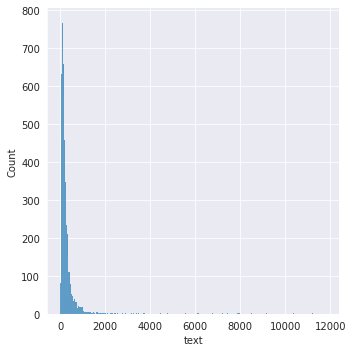

In [29]:
# Do a distribution plot on the seqquence length's of the given text
sns.set_style('darkgrid')
plt.figure.Figure(figsize=(16,10))
sns.displot(seqlen)

In [30]:
# Maximum length of the text we are going to train and predict here
SEQ_LEN = 300

## Encode Input Data
Encode the Input-Tensor and the Attention Tensor.

In [31]:
from transformers import AutoTokenizer, TFAutoModel
tranformersPreTrainedModelName = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(tranformersPreTrainedModelName) 

In [32]:
tokens = tokenizer.encode_plus('Hello World'
                               ,max_length = SEQ_LEN          # Using text with this max length
                               ,truncation=True               # truncate any text longer than max_length
                               ,padding='max_length'          # padd text that is smaller than max_length
                               ,add_special_tokens=True       # add special tokens for start, end of sentence, unknown, and mask tokens
                               ,return_token_type_ids = False # do not return ids for types of tokens
                               ,return_attention_mask = True
                               ,return_tensors='tf')

In [33]:
# Outputs 2 tensors named 'input_ids' & 'attention_mask'
# The values 101 and 102 are start and end of sentence identifiers
# while 7592 & 2088 are tokens for 'Hello World'
#
# Attention Mask tells Bert which tokens to pay attention to and which to ompletely ignore
print (tokens)

{'input_ids': <tf.Tensor: shape=(1, 300), dtype=int32, numpy=
array([[ 101, 7592, 2088,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 

### Tokenize each Sample in Dataset

In [34]:
import numpy as np
# initialize numpy arrays for Token-Ids and Attention Masks
Xids = np.zeros((len(df), SEQ_LEN))
Xmask = np.zeros((len(df), SEQ_LEN))

In [35]:
Xids.shape

(11270, 300)

In [36]:
# Use a simple for loop to encode all data points
for i, sequence in enumerate(df['text']):
  tokens = tokenizer.encode_plus(sequence
                               ,max_length = SEQ_LEN          # Using text with this max length
                               ,truncation=True               # truncate any text longer than max_length
                               ,padding='max_length'          # padd text that is smaller than max_length
                               ,add_special_tokens=True       # add special tokens for start, end of sentence, unknown, and mask tokens
                               ,return_token_type_ids = False # do not return ids for types of tokens
                               ,return_attention_mask = True
                               ,return_tensors='tf')
  
  Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']

In [37]:
# Array of tokenized Ids
Xids

array([[ 101., 2013., 1024., ...,    0.,    0.,    0.],
       [ 101., 2013., 1024., ..., 2151., 1997.,  102.],
       [ 101., 2013., 1024., ..., 1998., 4556.,  102.],
       ...,
       [ 101., 2013., 1024., ..., 1011., 1011.,  102.],
       [ 101., 2013., 1024., ..., 1037., 2261.,  102.],
       [ 101., 2013., 1024., ...,    0.,    0.,    0.]])

In [38]:
# Array of attaention masks
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.]])

### Save Tokenized Data

In [39]:
with open ('xids.npy', 'wb') as f:
  np.save(f, Xids)
with open ('xmask.npy', 'wb') as f:
  np.save(f, Xmask)
with open ('labels.npy', 'wb') as f:
  np.save(f, labels)

del df, Xids, Xmask, labels
df = None

## Ininitializing Hugging Face Tokenizer and Model

### Load Tokenized Data

In [40]:
import numpy as np
with open ('xids.npy', 'rb') as f:
  Xids = np.load(f)
with open ('xmask.npy', 'rb') as f:
  Xmask = np.load(f)
with open ('labels.npy', 'rb') as f:
  labels = np.load(f)

In [41]:
Xids

array([[ 101., 2013., 1024., ...,    0.,    0.,    0.],
       [ 101., 2013., 1024., ..., 2151., 1997.,  102.],
       [ 101., 2013., 1024., ..., 1998., 4556.,  102.],
       ...,
       [ 101., 2013., 1024., ..., 1011., 1011.,  102.],
       [ 101., 2013., 1024., ..., 1037., 2261.,  102.],
       [ 101., 2013., 1024., ...,    0.,    0.,    0.]])

In [42]:
for i in range(0, 20):
  print(labels[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1

In [43]:
import tensorflow as tf
#tf.config.list_physical_device('GPU')

In [44]:
# TensorFlow expects input and target labels as an input tuple
# Bert expects a dictionary of 'input_ids' and 'attention_mask' as input
# So, lets create the dataset object
# This creates a generator for a tuple of input tokens, attention_masks, and target labels
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [45]:
# View a single row in the dataset
print (dataset.take(1))
print ()
for i in dataset.take(1):
  print (i)

<TakeDataset shapes: ((300,), (300,), (20,)), types: (tf.float64, tf.float64, tf.float64)>

(<tf.Tensor: shape=(300,), dtype=float64, numpy=
array([  101.,  2013.,  1024.,  1006.,  1007.,  3395.,  1024.,  2128.,
        1024., 12469.,  2369., 27055.,  1029.,  2129.,  1029.,  3720.,
        1011.,  1045.,  1012.,  1040.,  1012.,  1024., 12943.,  3686.,
        1012.,  1015., 13876., 28154.,  2475.,  1002.,  1042.,  2683.,
        2050.,  3029.,  1024.,  2118.,  1997.,  2662.,  1010.,  8256.,
        3210.,  1024.,  2260.,  1050.,  3372.,  2361.,  1011., 14739.,
        1011.,  3677.,  1024., 11721., 26573.,  1012.,  8256.,  1012.,
        3968.,  2226.,  7009.,  1024.,  5253.,  1998., 22789.,  2097.,
        2031.,  3690.,  1005.,  1055.,  1015.,  2448.,  3020.,  2084.,
        2197.,  2095.,  1010.,  1998.,  1996., 12469.,  2097.,  2022.,
       28781.,  1998.,  2025.,  6510.,  5292., 25074.,  2100.,  2004.,
        2172.,  2004.,  7632., 22414.,  4103.,  1012., 19371.,  2180.,
       

In [46]:
# minute 21:55
# TensorFlow Bert model expects our input in a Tuple format containing:
# 1) 'input_ids' and 'attention_mask' in a Dictionary and
# 2) a label as 2nd part of the tupel
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [47]:
# we can use the dataset map function to apply this format
dataset = dataset.map(map_func)

In [48]:
# View a single row in the dataset
print (dataset.take(1))
print ()
for i in dataset.take(1):
  print (i)

<TakeDataset shapes: ({input_ids: (300,), attention_mask: (300,)}, (20,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

({'input_ids': <tf.Tensor: shape=(300,), dtype=float64, numpy=
array([  101.,  2013.,  1024.,  1006.,  1007.,  3395.,  1024.,  2128.,
        1024., 12469.,  2369., 27055.,  1029.,  2129.,  1029.,  3720.,
        1011.,  1045.,  1012.,  1040.,  1012.,  1024., 12943.,  3686.,
        1012.,  1015., 13876., 28154.,  2475.,  1002.,  1042.,  2683.,
        2050.,  3029.,  1024.,  2118.,  1997.,  2662.,  1010.,  8256.,
        3210.,  1024.,  2260.,  1050.,  3372.,  2361.,  1011., 14739.,
        1011.,  3677.,  1024., 11721., 26573.,  1012.,  8256.,  1012.,
        3968.,  2226.,  7009.,  1024.,  5253.,  1998., 22789.,  2097.,
        2031.,  3690.,  1005.,  1055.,  1015.,  2448.,  3020.,  2084.,
        2197.,  2095.,  1010.,  1998.,  1996., 12469.,  2097.,  2022.,
       28781.,  1998.,  2025.,  6510.,  5292., 25074.,  2100.,  2004.,
      

In [49]:
# SHuffle and Bach Dataset
dataset = dataset.shuffle(1000).batch(32)

In [50]:
# Get the total size of dataset now that it is batched
#
# the dataset object is a generator object so we cannot take the length of it directly
# thus, we have to convert it into a list
# 
# Do not do this with a very large dataset
#
DS_LEN = len(list(dataset))
DS_LEN

353

In [51]:
print (f"Alternative Computation for DS_LEN: {len(Xids)/32} -> {round(len(Xids)/32, 0)}")

Alternative Computation for DS_LEN: 352.1875 -> 352.0


In [52]:
SPLIT = .9

# take or skip the specified number of batches to split by factor
train = dataset.take(round(DS_LEN * SPLIT))
evalu = dataset.skip(round(DS_LEN * SPLIT))

del dataset

## Build Model

In [53]:
from transformers import TFAutoModel
tranformersPreTrainedModelName = 'bert-base-uncased'
bert = TFAutoModel.from_pretrained(tranformersPreTrainedModelName)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [54]:
def CreateGlobalMaxPool1D_Model():
  # build 2 input layers to Bert Model where name needs to match the input values in the dataset
  input_ids = tf.keras.Input(shape=(SEQ_LEN,), name = 'input_ids', dtype='int32')
  mask = tf.keras.Input(shape=(SEQ_LEN,), name = 'attention_mask', dtype='int32')

  # Pool embedings from initializer bert model by consuming the input layers
  # This will return 2 Tensors:
  # 1st output is the Last Hidden State - a 3D tensor of the last Hidden layer of the Bert model
  # which can be used to further process the output from the pre-trained embedding layer 
  embedings = bert(input_ids, attention_mask=mask)[0]

  # 2nd tensor output is called the Pooler output
  # is the pooled output of the last hidden state run through a feed forward or linaer activation function
  # that creates a 2D tensor that can be used for classification
  # but we ignore it and do classification ourselves by pooling it ourself
  #embedings = bert(input=input_ids, attention_mask=mask)[1]

  X = tf.keras.layers.GlobalMaxPool1D()(embedings)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.Dense(128, activation='relu')(X)
  X = tf.keras.layers.Dropout(0.1)(X)
  X = tf.keras.layers.Dense(32, activation='relu')(X)
  y = tf.keras.layers.Dense(len(label2Index), activation='softmax', name='outputs')(X)

  model = tf.keras.Model(inputs=[input_ids,mask], outputs=y)

  # Freeze the Bert model by freezing this layer to make training less of an overkill in terms of required GPU memory
  model.layers[2].trainable = False

  return model

In [55]:
def CreateBidirectionalLSTM_Model():
  # build 2 input layers to Bert Model where name needs to match the input values in the dataset
  input_ids = tf.keras.Input(shape=(SEQ_LEN,), name = 'input_ids', dtype='int32')
  mask = tf.keras.Input(shape=(SEQ_LEN,), name = 'attention_mask', dtype='int32')

  # Pool embedings from initializer bert model by consuming the input layers
  # This will return 2 Tensors:
  # 1st output is the Last Hidden State - a 3D tensor of the last Hidden layer of the Bert model
  # which can be used to further process the output from the pre-trained embedding layer 
  embedings = bert(input_ids, attention_mask=mask)[0]

  # 2nd tensor output is called the Pooler output
  # is the pooled output of the last hidden state run through a feed forward or linaer activation function
  # that creates a 2D tensor that can be used for classification
  # but we ignore it and do classification ourselves by pooling it ourself
  #embedings = bert(input=input_ids, attention_mask=mask)[1]

  #Original Author: Ferry Djaja
  #https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592
  X = tf.keras.layers.Dropout(0.1)(embedings)
  X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768))(X)
  y = tf.keras.layers.Dense(len(label2Index), activation='softmax', name='outputs')(X)

  model = tf.keras.Model(inputs=[input_ids,mask], outputs=y)

  # Freeze the Bert model by freezing this layer to make training less of an overkill in terms of required performance
  model.layers[2].trainable = False

  return model

In [56]:
model = CreateBidirectionalLSTM_Model()
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 300)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
_____________________________________________________

## Define Optimizer, Metrics, and Loss

In [57]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
#loss = tf.keras.losses.CategoricalCrossentropy()
#accuracy = tf.keras.metrics.CategoricalAccuracy('accuracy')
#model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])


loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
    )

## Train the Model

In [58]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()

history = model.fit(train, validation_data=evalu, epochs=6)

end = timer()
print(timedelta(seconds=end-start))

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/6


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


318/318 [==============================] - ETA: 0s - loss: 1.8299 - accuracy: 0.4097

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


318/318 [==============================] - 459s 1s/step - loss: 1.8283 - accuracy: 0.4101 - val_loss: 0.7759 - val_accuracy: 0.7313
Epoch 2/6
318/318 [==============================] - 423s 1s/step - loss: 0.7069 - accuracy: 0.7612 - val_loss: 0.4284 - val_accuracy: 0.8583
Epoch 3/6
318/318 [==============================] - 424s 1s/step - loss: 0.4511 - accuracy: 0.8475 - val_loss: 0.3402 - val_accuracy: 0.8885
Epoch 4/6
318/318 [==============================] - 424s 1s/step - loss: 0.3148 - accuracy: 0.8959 - val_loss: 0.3050 - val_accuracy: 0.9004
Epoch 5/6
318/318 [==============================] - 425s 1s/step - loss: 0.2296 - accuracy: 0.9234 - val_loss: 0.2123 - val_accuracy: 0.9324
Epoch 6/6
318/318 [==============================] - 425s 1s/step - loss: 0.1661 - accuracy: 0.9444 - val_loss: 0.2223 - val_accuracy: 0.9342
0:43:00.057848


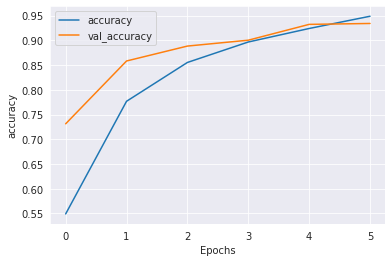

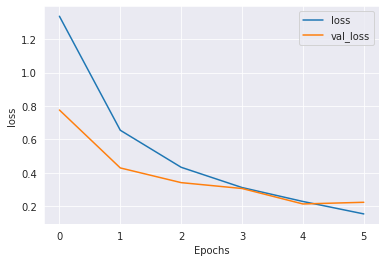

In [59]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Informal Test of Model

In [60]:
pred_sentences = ['This season so far, Morgan and Guzman helped to lead the Cubs at top in ERA, even better than THE rotation at Atlanta.',                  # rec.sport.baseball
                  'This is the tenth of ten parts of the sci.crypt FAQ.',                                                                                    # sci.crypt
                  'I think that domestication will change behavior to a large degree. Domesticated animals exhibit behaviors not found in the wild.',
                  "If anybody wants these changes, they're welcome to them, but you'll have to have the source available and be comfortable munging with it a bit."] # comp.windows.x

In [93]:
testString = pred_sentences[0]
tf_batch = tokenizer.encode_plus(testString
                                ,max_length = SEQ_LEN          # Using text with this max length
                                ,truncation=True               # truncate any text longer than max_length
                                ,padding='max_length'          # padd text that is smaller than max_length
                                ,add_special_tokens=True       # add special tokens for start, end of sentence, unknown, and mask tokens
                                ,return_token_type_ids = False # do not return ids for types of tokens
                                ,return_attention_mask = True
                                ,return_tensors='tf')

In [94]:
tf_outputs = model(tf_batch)

# Get index of predicted label for each sentence
labelIdx = tf.argmax(tf_outputs, axis=1).numpy()[0]

print (f"{testString}")
print (f"label: {labelIdx} PropValue: {tf_outputs[0][labelIdx]} Label: {index2label[labelIdx]}")
print (f"{tf_outputs}")

This season so far, Morgan and Guzman helped to lead the Cubs at top in ERA, even better than THE rotation at Atlanta.
label: 14 PropValue: 0.3639847934246063 Label: sci.space
[[0.0492133  0.07213993 0.03000852 0.00263356 0.06899282 0.12541668
  0.00746241 0.00955032 0.00152745 0.00388518 0.03602331 0.0051667
  0.01173944 0.11081531 0.3639848  0.05327093 0.0209004  0.01460669
  0.00429226 0.00836998]]
